<a href="https://colab.research.google.com/github/NicoFuentese/Ciencia_De_Datos_TD2025/blob/main/8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#dependencias
import sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
print('Python:', sys.version.split()[0])
print('TensorFlow:', tf.__version__)

# Opciones de display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

Python: 3.12.11
TensorFlow: 2.19.0


In [ ]:
# === 1) Carga y exploración ===
CSV_PATH = 'dataset_natalidad.csv'  # Cambia si subes a Colab con otro nombre
df = pd.read_csv(CSV_PATH)

# Identificar columnas
label_col = 'Tasa_Natalidad'
id_cols = [c for c in ['País', 'Pais', 'Country'] if c in df.columns]
feature_cols = [c for c in df.columns if c not in id_cols + [label_col]]

print('Filas x columnas:', df.shape)
print('Columna objetivo:', label_col)
print('Predictoras:', feature_cols)
display(df.head())

Filas x columnas: (100, 8)
Columna objetivo: Tasa_Natalidad
Predictoras: ['PIB_per_capita', 'Acceso_Salud', 'Nivel_Educativo', 'Tasa_Empleo_Femenino', 'Edad_Maternidad', 'Urbanizacion']


,País,PIB_per_capita,Acceso_Salud,Nivel_Educativo,Tasa_Empleo_Femenino,Edad_Maternidad,Urbanizacion,Tasa_Natalidad
0,País_1,25599.706537,51.571459,14.630475,32.584086,21.546858,71.889703,38.613409
1,País_2,57289.286853,81.820521,6.262099,56.567732,33.538294,62.165782,19.211764
2,País_3,45259.666800,65.717799,7.424431,57.031756,27.578786,48.571657,26.556891
3,País_4,37926.216631,75.428535,18.478313,61.871495,32.396862,78.827701,29.177172
4,País_5,13581.025224,95.378324,14.096436,66.304567,24.800744,71.083870,40.000000


,PIB_per_capita,Acceso_Salud,Nivel_Educativo,Tasa_Empleo_Femenino,Edad_Maternidad,Urbanizacion,Tasa_Natalidad
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,30859.940886,74.891586,12.764020,54.557447,27.740687,61.517985,32.547017
std,16361.917606,14.655563,4.401394,14.672611,4.779013,17.827325,7.379215
min,5303.716442,50.347607,5.075924,30.719674,20.162565,30.872680,13.057745
25%,15626.041838,62.100226,9.153198,42.480746,23.959023,45.331219,26.898090
50%,30527.835008,75.281243,13.438324,55.485915,27.880992,61.692122,34.584812
75%,45161.171556,88.309180,16.285504,66.788876,31.953263,78.668415,39.923995
max,59278.781513,99.282523,19.850808,79.525257,34.894472,89.983060,40.000000


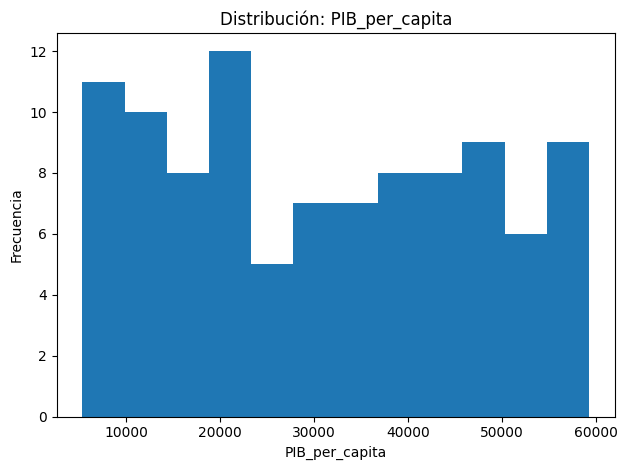

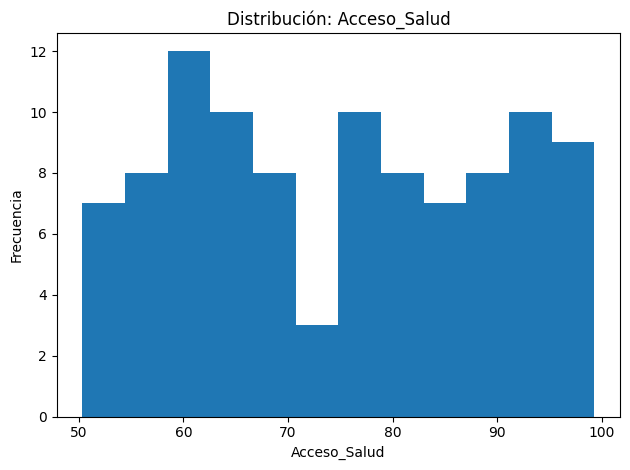

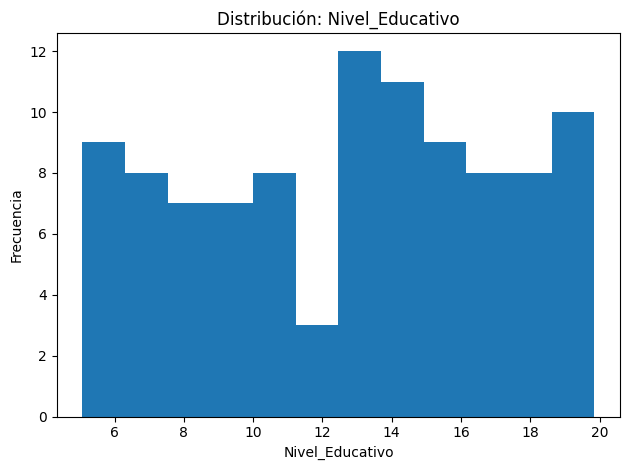

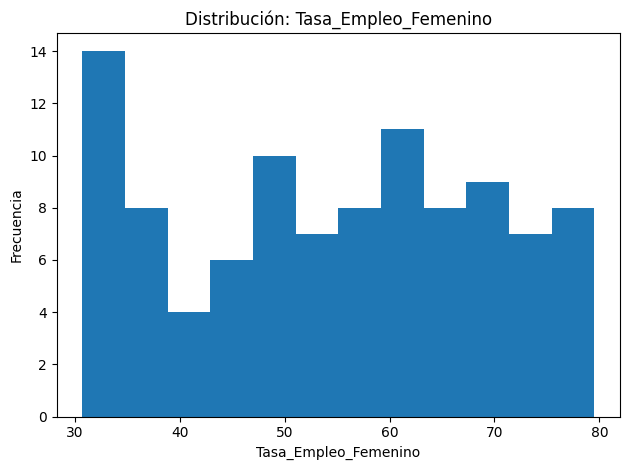

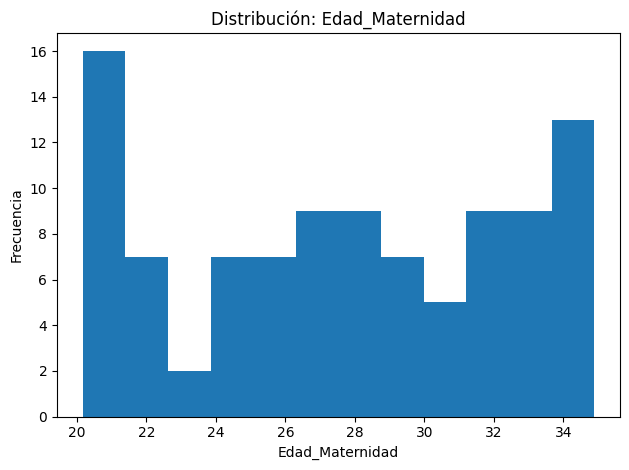

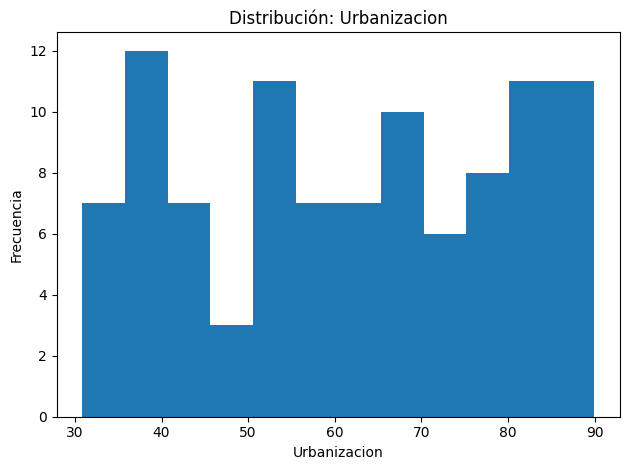

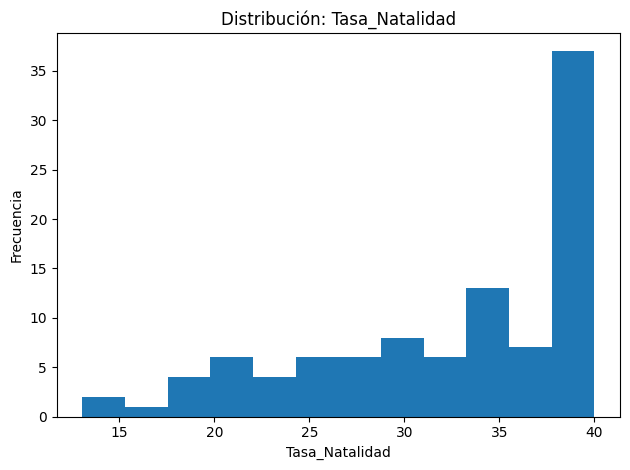

Matriz de correlación:


,PIB_per_capita,Acceso_Salud,Nivel_Educativo,Tasa_Empleo_Femenino,Edad_Maternidad,Urbanizacion,Tasa_Natalidad
PIB_per_capita,1.000000,-0.034033,-0.037654,-0.211882,0.120075,0.069321,-0.866007
Acceso_Salud,-0.034033,1.000000,-0.146354,-0.011783,-0.082393,-0.228878,0.076261
Nivel_Educativo,-0.037654,-0.146354,1.000000,-0.214816,-0.034695,-0.021957,-0.124269
Tasa_Empleo_Femenino,-0.211882,-0.011783,-0.214816,1.000000,0.187530,-0.218485,0.242314
Edad_Maternidad,0.120075,-0.082393,-0.034695,0.187530,1.000000,-0.133339,-0.300375
Urbanizacion,0.069321,-0.228878,-0.021957,-0.218485,-0.133339,1.000000,0.204841
Tasa_Natalidad,-0.866007,0.076261,-0.124269,0.242314,-0.300375,0.204841,1.000000


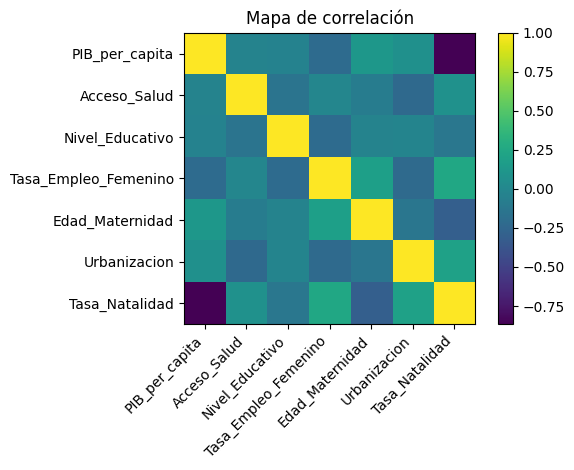

In [ ]:
# Descripción
display(df[feature_cols + [label_col]].describe())

# Histograma una variable por figura (sin estilos ni colores específicos)
for col in feature_cols + [label_col]:
    plt.figure()
    plt.hist(df[col].dropna().values, bins=12)
    plt.title(f'Distribución: {col}')
    plt.xlabel(col); plt.ylabel('Frecuencia')
    plt.tight_layout(); plt.show()

# Correlaciones: matriz + mapa (matplotlib imshow)
corr = df[feature_cols + [label_col]].corr()
print('Matriz de correlación:'); display(corr)

plt.figure()
plt.imshow(corr.values, interpolation='nearest')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Mapa de correlación')
plt.colorbar()
plt.tight_layout(); plt.show()

In [ ]:
# === Split y escalado ===
X = df[feature_cols].values.astype(float)
y = df[label_col].values.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_sc[:3]

array([[ 1.55811593, -0.91237616,  0.14602181,  0.46697651, -0.10978473,
        -0.34478906],
       [ 1.43909981,  0.08739536, -0.78540124,  0.85264441,  1.35716336,
        -1.27195563],
       [-0.92168212,  1.08983975,  1.58044389,  0.15306383, -0.27351421,
        -0.30662807]])

In [ ]:
# === 2) Diseño del modelo (fábrica de modelos) ===
def build_mlp(input_dim, hidden_units=(64, 32), activation='relu', l2=0.0, dropout=0.0, lr=1e-3, optimizer='adam'):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for i, units in enumerate(hidden_units):
        model.add(layers.Dense(units, activation=activation,
                               kernel_regularizer=regularizers.l2(l2) if l2>0 else None))
        if dropout>0:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='linear'))
    opt = None
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    elif optimizer == 'rmsprop':
        opt = keras.optimizers.RMSprop(learning_rate=lr)
    else:
        opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse', metrics=[keras.metrics.RootMeanSquaredError(name='rmse'), 'mae'])
    return model

def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

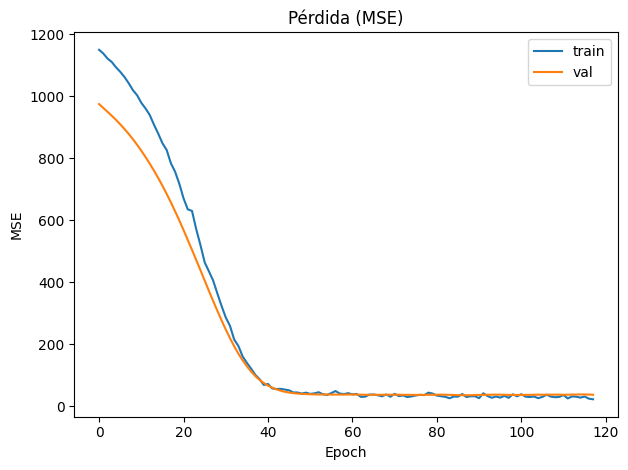

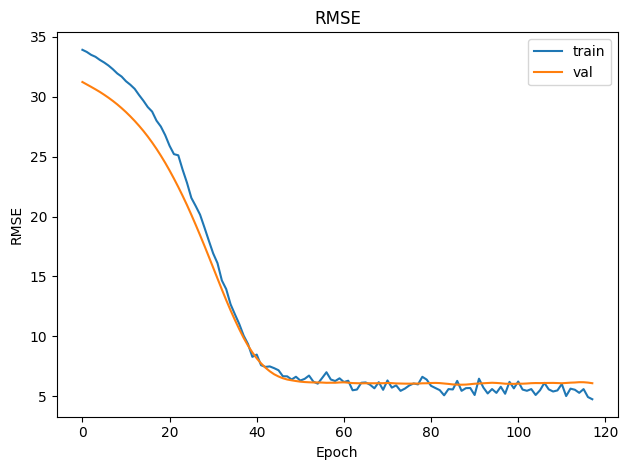

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Métricas base: {'RMSE': np.float64(5.267294763951822), 'MAE': 4.425417781621215, 'R2': 0.6142037215307522}


In [ ]:
# Entrenamiento base con EarlyStopping
params = {
    'hidden_units': (64, 32),
    'activation': 'relu',          # probaremos otras abajo
    'l2': 1e-4,
    'dropout': 0.1,
    'lr': 1e-3,
    'optimizer': 'adam'
}
model = build_mlp(input_dim=X_train_sc.shape[1], **params)
es = keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True, monitor='val_loss')
hist = model.fit(X_train_sc, y_train, validation_split=0.2, epochs=500, batch_size=16, verbose=0, callbacks=[es])

# Curva de entrenamiento (una figura por métrica)
plt.figure()
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('Pérdida (MSE)')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure()
plt.plot(hist.history['rmse'], label='train')
plt.plot(hist.history['val_rmse'], label='val')
plt.title('RMSE'); plt.xlabel('Epoch'); plt.ylabel('RMSE'); plt.legend(); plt.tight_layout(); plt.show()

# Evaluación
y_pred = model.predict(X_test_sc).ravel()
metrics_base = evaluate_regression(y_test, y_pred)
print('Métricas base:', metrics_base)

In [ ]:
# === 3) Búsqueda simple de hiperparámetros ===
activations = ['relu', 'tanh']
optimizers = ['adam', 'rmsprop']
lrs = [1e-3, 5e-4]
dropouts = [0.0, 0.1]
l2s = [0.0, 1e-4]

results = []
for act in activations:
    for opt in optimizers:
        for lr in lrs:
            for do in dropouts:
                for l2 in l2s:
                    tf.keras.backend.clear_session()
                    m = build_mlp(X_train_sc.shape[1], hidden_units=(64,32), activation=act, l2=l2, dropout=do, lr=lr, optimizer=opt)
                    es = keras.callbacks.EarlyStopping(patience=25, restore_best_weights=True, monitor='val_loss')
                    h = m.fit(X_train_sc, y_train, validation_split=0.2, epochs=400, batch_size=16, verbose=0, callbacks=[es])
                    pred = m.predict(X_test_sc).ravel()
                    met = evaluate_regression(y_test, pred)
                    results.append({'activation': act, 'optimizer': opt, 'lr': lr, 'dropout': do, 'l2': l2, **met})

res_df = pd.DataFrame(results).sort_values(['RMSE','MAE','R2'], ascending=[True, True, False])
display(res_df.head(10))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━

,activation,optimizer,lr,dropout,l2,RMSE,MAE,R2
27,tanh,rmsprop,0.0010,0.1,0.0001,1.782764,1.479276,0.955805
26,tanh,rmsprop,0.0010,0.1,0.0000,1.979411,1.674383,0.945518
18,tanh,adam,0.0010,0.1,0.0000,3.021869,2.602755,0.873020
24,tanh,rmsprop,0.0010,0.0,0.0000,3.249979,2.756845,0.853126
19,tanh,adam,0.0010,0.1,0.0001,3.490517,2.989995,0.830581
8,relu,rmsprop,0.0010,0.0,0.0000,3.561902,2.977234,0.823580
25,tanh,rmsprop,0.0010,0.0,0.0001,3.567007,3.123455,0.823074
9,relu,rmsprop,0.0010,0.0,0.0001,3.945190,3.371745,0.783569
11,relu,rmsprop,0.0010,0.1,0.0001,4.001564,3.401739,0.777340
13,relu,rmsprop,0.0005,0.0,0.0001,4.227481,3.627720,0.751489


In [ ]:
# Seleccionar mejor combinación y re-entrenar
best = res_df.iloc[0]
print('Mejores hiperparámetros:', best.to_dict())

best_model = build_mlp(
    input_dim=X_train_sc.shape[1],
    hidden_units=(64,32),
    activation=str(best['activation']),
    l2=float(best['l2']),
    dropout=float(best['dropout']),
    lr=float(best['lr']),
    optimizer=str(best['optimizer'])
)
es = keras.callbacks.EarlyStopping(patience=40, restore_best_weights=True, monitor='val_loss')
hist_best = best_model.fit(X_train_sc, y_train, validation_split=0.2, epochs=600, batch_size=16, verbose=0, callbacks=[es])


Mejores hiperparámetros: {'activation': 'tanh', 'optimizer': 'rmsprop', 'lr': 0.001, 'dropout': 0.1, 'l2': 0.0001, 'RMSE': 1.7827641957217304, 'MAE': 1.4792760392950859, 'R2': 0.9558052587780991}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Métricas finales: {'RMSE': np.float64(1.4781965417381961), 'MAE': 1.1728803153613092, 'R2': 0.9696158457298418}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━

,Aumento_RMSE_por_permutación
PIB_per_capita,7.666077
Urbanizacion,2.470256
Edad_Maternidad,1.334309
Tasa_Empleo_Femenino,1.207220
Nivel_Educativo,0.831830
Acceso_Salud,-0.028042


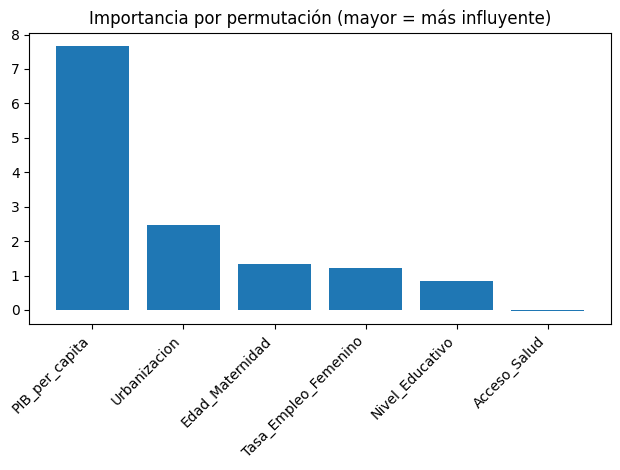

In [ ]:
# Evaluación final
y_pred_best = best_model.predict(X_test_sc).ravel()
metrics_best = evaluate_regression(y_test, y_pred_best)
print('Métricas finales:', metrics_best)

# === Importancia por permutación ===
def permutation_importance(model, X_sc, y_true, metric_func, n_repeats=10, random_state=42):
    rng = np.random.default_rng(random_state)
    base_pred = model.predict(X_sc).ravel()
    base = metric_func(y_true, base_pred)  # usamos RMSE
    importances = []
    for j in range(X_sc.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_perm = X_sc.copy()
            idx = rng.permutation(len(X_sc))
            X_perm[:, j] = X_perm[idx, j]
            pred = model.predict(X_perm).ravel()
            s = metric_func(y_true, pred)
            scores.append(s - base)  # aumento en RMSE
        importances.append(np.mean(scores))
    return np.array(importances)

rmse_metric = lambda y_true, yhat: np.sqrt(mean_squared_error(y_true, yhat))
imp = permutation_importance(best_model, X_test_sc, y_test, rmse_metric, n_repeats=20)
imp_series = pd.Series(imp, index=feature_cols).sort_values(ascending=False)
display(imp_series.to_frame('Aumento_RMSE_por_permutación'))

# Gráfico de importancias (una figura)
plt.figure()
plt.bar(imp_series.index.astype(str), imp_series.values)
plt.xticks(rotation=45, ha='right')
plt.title('Importancia por permutación (mayor = más influyente)')
plt.tight_layout(); plt.show()

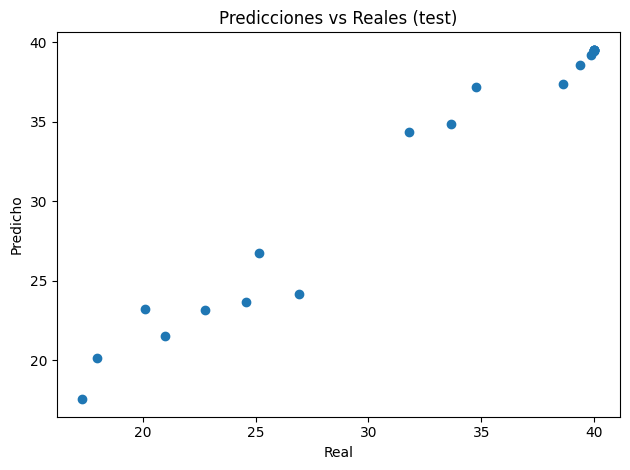

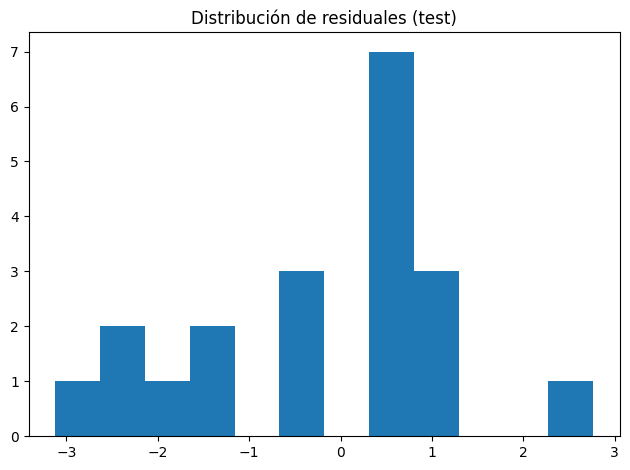

,Real,Predicho
0,40.000000,39.503639
1,17.986387,20.117086
2,25.175231,26.761108
3,20.110443,23.229704
4,39.376825,38.562084
5,31.805208,34.386349
6,40.000000,39.531918
7,17.335923,17.548189
8,40.000000,39.525620
9,38.613409,37.398251


In [ ]:
# === 4) Predicciones vs reales ===
plt.figure()
plt.scatter(y_test, y_pred_best)
plt.xlabel('Real'); plt.ylabel('Predicho')
plt.title('Predicciones vs Reales (test)')
plt.tight_layout(); plt.show()

# Residuales
resid = y_test - y_pred_best
plt.figure()
plt.hist(resid, bins=12)
plt.title('Distribución de residuales (test)')
plt.tight_layout(); plt.show()

# Tabla comparativa
comparacion = pd.DataFrame({'Real': y_test, 'Predicho': y_pred_best})
display(comparacion.head(10))

In [ ]:
# === Guardado opcional del modelo y scaler ===
best_model.save('modelo_natalidad_keras.h5')
import joblib
joblib.dump(scaler, 'scaler.pkl')

print('Guardado: modelo_natalidad_keras.h5 y scaler.pkl')

Guardado: modelo_natalidad_keras.h5 y scaler.pkl


## 5) Conclusiones (plantilla)

- **Variables más influyentes**: según importancia por permutación, comente por qué podrían impactar la natalidad (p. ej., mayor **Edad_Maternidad** suele asociarse a menor natalidad; mayor **Acceso_Salud** podría correlacionar con planificación y cambios en tasa, etc.).
- **Rendimiento del mejor modelo**: reporte RMSE, MAE, R² del set de prueba.
- **Relación con tendencias globales**: discuta urbanización, educación y empleo femenino en relación con patrones demográficos habituales.
- **Mejoras futuras**: añadir *feature engineering*, más datos, validación cruzada más robusta, tuning sistemático (Optuna/KerasTuner), y evaluación de modelos complementarios (XGBoost/RandomForest) como *baseline* comparativo.